# Predicting gender from blog post

## Note to Preet: In this notebook I'm combining some categories and taking out "Industry Unknown". My f1 score is MUCH better when I do this. However, I'm not sure it's appropriate because I'm predicting 'gender' here and I'm not even adding 'topic' as a feature.

## Plot distribution of word counts
## Plotted ROC curve
## Need to plot most common words by category

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
df = pd.read_csv('blogtext.csv', parse_dates = ['date']).sample(8000)

In [2]:
df = df[df['topic']!='indUnk'].copy()
# df = df[df['topic']!='Student'].copy()
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,age,topic,sign,date,text
0,3293712,male,16,Student,Taurus,"19,May,2004","Alright Mattson, I believe it is spelle..."
1,3304877,male,26,Technology,Aries,"21,May,2004",i have a urlLink gmail acco...
2,3955416,male,37,Technology,Virgo,"20,July,2004",It is only a few days left before t...
3,320317,male,36,Technology,Pisces,"25,July,2002",'The FCC reports that there were 12...
4,3495224,male,16,Student,Aries,"02,June,2004",urlLink VH-AFR Resting on the GA ramp a...


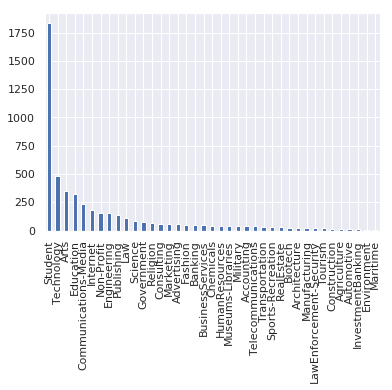

In [3]:
#Removing all classes but the 20 most populous.
# most_pop = list(df.groupby('topic')['topic'].agg('count').sort_values(ascending=False)[:20].index)
# df = df[df['topic'].isin(most_pop)]
# print(df.shape)
# plt.figure(figsize=(9,9))
# df['topic'].value_counts().plot('bar')
#A lot of these classes are super similar. I might need to combine them.

# Alright, time to combine a few categories

In [4]:
#First create a new column for edited categories
TYPEDICT = {'Advertising':'Marketing', 'Internet':'Technology', 
            'BusinessServices':'Consulting', 'Telecommunications':'Communications-Media', 
            'Publishing':'Communications-Media', 'Government':'Law', 'Banking': 'Finance', 
            'Accounting': 'Finance', 'Science': 'Science&Engineering', 'Engineering':'Science&Engineering'}
df['custom_topic'] = df['topic'].map(lambda x: TYPEDICT[x] if x in TYPEDICT else x)

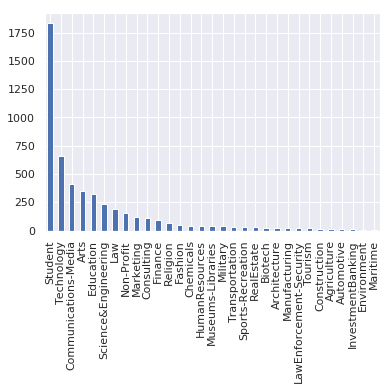

In [5]:
df['custom_topic'].value_counts().plot('bar')

In [7]:
#Tokenizing and Lemmatizing text.
import spacy
import re
nlp = spacy.load('en_core_web_sm')

#Creating the tokens, which are an important spaCy datatype.
df['tokens'] = df['text'].apply(lambda x: nlp.tokenizer(x.lower()))
spacy_stopwords = [spacy.lang.en.stop_words.STOP_WORDS] + ['urllink']
stops = ['and', 'the', 'is', 'are', 'urllink', 'of', 'PRON']
#Turning the tokens to Python datatypes and cleaning, for non-spaCy work.
def clean(lst):
#     lst = [token.lemma_ for token in lst if not token.is_stop]
    lst = [token.lemma_ for token in lst if str(token.lemma_) not in stops]
    lst = [l.replace('nbsp', '').replace('urllink', '') for l in lst]
    lst = [re.sub(r'[\W]', '', string) for string in lst]
    while '' in lst:
        lst.remove('')
    return lst
df['formatted'] = df['tokens'].map(lambda x: clean(x))
df['tokenstr'] = df['tokens'].map(lambda x: str(x))
#Creating a single-string version of the cleaned texts, for tools that require it.
df['form_str'] = df['formatted'].map(lambda x: ' '.join(x))
df['formatted'].head()

0    [alright, mattson, i, believe, it, be, spell, ...
1    [i, have, a, gmail, account, now, but, i, must...
2    [it, be, only, a, few, day, leave, before, mov...
3    [fcc, report, that, there, be, 128, million, b...
4    [vh, afr, rest, on, ga, ramp, after, a, long, ...
Name: formatted, dtype: object

In [10]:
#Turn tokens to string
list(nlp.vocab.strings)[:20]

['""',
 '#',
 '$',
 "''",
 ',',
 '-LRB-',
 '-RRB-',
 '.',
 ':',
 'ADD',
 'AFX',
 'BES',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'GW',
 'HVS',
 'HYPH']

In [11]:
df['tokenstr'].tail(30)
#urllink is still here.

5005           thanks to the members of st. blog's who...
5006               so, i finally found a place to live...
5007                  urllink still no case for war  [...
5008                      urllink múm ( summer make go...
5009                 it is better to have loved and lo...
5010               [beej@localhost beej]blogger: permi...
5011               weller words pop into mind. he was ...
5012                 ok, i feel kinda bad. i feel like...
5013           i would just like to praise the lord je...
5014                      urllink    matt and evan at ...
5015           alright, so today i got up early to let...
5016            .scene  today i got to go to work with...
5017                urllink    after....&nbsp; urllink...
5018                 so tom ridge is out there today p...
5019               i'm going to a styx and peter framp...
5020                 so.  maurice clarett decided to c...
5021           die liao. this time really die liao. i'...
5022          

# Do word counts by class

<Figure size 648x648 with 0 Axes>

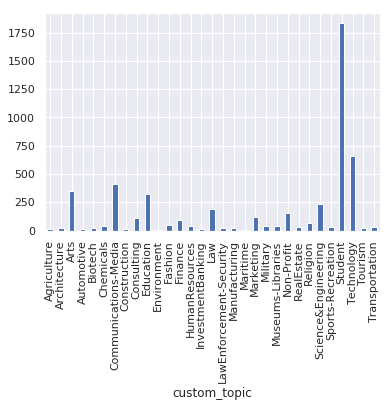

<Figure size 648x648 with 0 Axes>

In [12]:
#Want to plot median word count by class
df.groupby('custom_topic')['tokens'].agg('count').plot('bar')
plt.figure(figsize=(9,9))
# df['custom_topic'].value_counts().plot('bar')

In [14]:
topics = list(df['custom_topic'].unique())
#find average length of the blogposts by class
def avlength(col):
    col.reset_index(drop=True,inplace=True)
    count = 0
    for i in range(1,len(col)):
        count += len(col[i])
    return count/(len(col))
avlength(df['tokens'])

254.06593843098312

In [ ]:
# Want the most common words by category: working on this.
from collections import Counter
# five most common tokens
words = df.loc[4]['tokens']
word_freq = Counter(words)
common_words = word_freq.most_common(5)
common_words

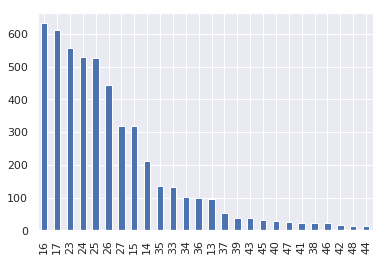

In [15]:
df.age.value_counts().plot('bar')

# Machine Learning Pre-Processing

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y=le.fit_transform(df['gender'])
# X = df['form_str']
X=df['tokenstr']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=True, analyzer = "word",
                     max_features=3500,min_df=4, tokenizer=None, 
                     ngram_range = [3,5], preprocessor=None)
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
#Metrics I'm going to use
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report

In [17]:
len(cv.vocabulary_)

3500

In [19]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.04)
clf = clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.596505162827641
F1 score:  0.6780735107731305


In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.5)
clf=clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5694996028594123
F1 score:  0.7005524861878454


Accuracy score:  0.5845909451945989
F1 score:  0.6405498281786942


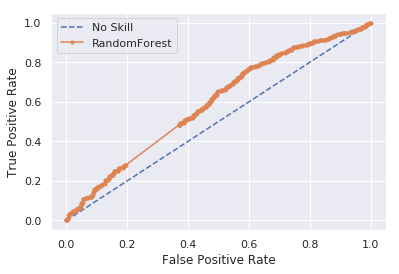

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#This is just the code for getting an AUC plot. I will stick it into a function.
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
ns_auc = roc_auc_score(y_test, ns_probs)
ns_auc

In [22]:
#Best score of anything. F1=.724346
from sklearn.svm import SVC
clf = SVC(gamma = 'auto', C=1, kernel='poly', degree=3)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

Accuracy score:  0.5607625099285147
F1 score:  0.7185750636132315


Accuracy score:  0.5861795075456712
F1 score:  0.7145205479452055


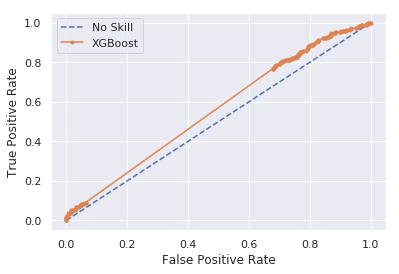

In [23]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=500, eta=0.05)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
probs = clf.predict_proba(X_test_cv)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [24]:
#Best score: .72599
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', C=0.08, solver='lbfgs')
# lr = LogisticRegression(penalty='elasticnet', C=0.2, solver='saga')

lr.fit(X_train_cv, y_train)
lr_bow_prediction = lr.predict(X_test_cv)

print (metrics.accuracy_score(y_test , lr_bow_prediction))
print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.5877680698967435
[[118 434]
 [ 85 622]]
F1 score:  0.7056154282473058
Precision score:  0.5890151515151515
Recall score:  0.8797736916548797


# Using tf-idf from gensim, not sklearn
Need Preet to look at this. I can't get it to work with ML models.

In [25]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dataset = df['formatted']
dct = Dictionary(dataset)  # fit dictionary
corpus = [dct.doc2bow(line) for line in dataset]  # convert corpus to BoW format

gtfidf = TfidfModel(corpus)  
# gensim_x = gtfidf(X_train)

In [27]:
# from gensim.models import TfidfModel
# test = TfidfModel(corpus)
# from gen
# vectors = [model[dictionary.doc2bow(doc)] for doc in X_train]
import gensim
X = df['form_str']

corpus  = [doc for doc in X_train]
lexicon = gensim.corpora.Dictionary(corpus)
tfidf   = gensim.models.TfidfModel(dictionary=lexicon, normalize=True)
vectors = [tfidf[lexicon.doc2bow(doc)] for doc in corpus]

In [ ]:
from gensim.sklearn_api import TfIdfTransformer
from gensim.corpora import Dictionary
X = df['formatted']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

dictionary = Dictionary(X_train)
model = TfIdfTransformer(dictionary)
train = [dictionary.doc2bow(text) for text in X_train]
test = [dictionary.doc2bow(text) for text in X_test]
X_train_g =  model.fit_transform(train)
X_test_g = model.fit_transform(test)

In [29]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = clf.fit(X_train_g, y_train)
y_preds=clf.predict(X_test_g)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(penalty='l2', max_iter=500, C=0.8, solver='lbfgs')
lgb.fit(X_train_g, y_train)
lr_bow_prediction = lgb.predict(X_test_g)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

# Using sklearn's tf-idf:

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(use_idf=True, min_df=3, analyzer='word', smooth_idf=True,
                       norm = 'l2', ngram_range=[3,5], sublinear_tf=True)
# X=df['form_str']
X=df['tokenstr']
X_train, X_test, y_train, y_test = train_test_split(X,y)
tfid_train_matrix = tfid.fit_transform(X_train)
tfid_test_matrix = tfid.transform(X_test)

In [31]:
#LightGBM is weak with NLP applications.
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=450, learning_rate=0.1, reg_alpha=0.2, reg_lambda=0)
lgb.fit(tfid_train_matrix, y_train)
lr_bow_prediction = lgb.predict(tfid_test_matrix)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

[[191 356]
 [179 533]]
F1 score:  0.6658338538413492
Precision score:  0.5995500562429696
Recall score:  0.7485955056179775


[[  0 547]
 [  0 712]]
F1 score:  0.7224759005580924
Precision score:  0.5655281969817315
Recall score:  1.0


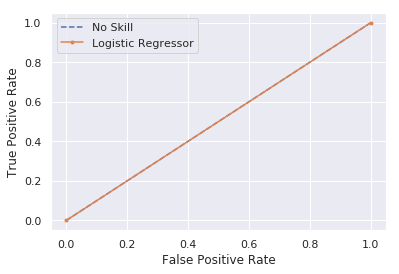

In [33]:
#Best score: .7266
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', max_iter=500, C=0.1, solver='liblinear', intercept_scaling=1.1)
lr.fit(tfid_train_matrix, y_train)
lr_bow_prediction = lr.predict(tfid_test_matrix)

print (metrics.confusion_matrix(y_test , lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

probs = lr.predict_proba(tfid_test_matrix)
lr_probs = probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regressor')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
#It's just guessing everything one gender. This is the worst-case scenario.

In [ ]:
from sklearn.metrics import precision_recall_curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_preds), roc_curve(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
#Best score .7266
from sklearn.naive_bayes import MultinomialNB, GaussianNB
clf = MultinomialNB(alpha=8.7)
# clf=GaussianNB(var_smoothing=1e-09)
clf = clf.fit(tfid_train_matrix.toarray(), y_train)
y_preds=clf.predict(tfid_test_matrix.toarray())
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=900, learning_rate=.25, min_samples_split=10)
clf.fit(tfid_train_matrix, y_train)
y_preds=clf.predict(tfid_test_matrix)
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

# Time to use Word2Vec

In [34]:
#Make tokenized versions of X_train
import nltk
X_train_tok = [nltk.word_tokenize(t) for t in X_train]
X_test_tok = [nltk.word_tokenize(t) for t in X_test]
from gensim.models import Word2Vec
w2vm = Word2Vec(X_train_tok, size=350, window=15, negative=2)
w2v = dict(zip(w2vm.wv.index2word, w2vm.wv.syn0))
w2vm.wv.index2entity[:15]

/home/drew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys


['.',
 ',',
 'the',
 'i',
 'to',
 'and',
 'a',
 'of',
 'it',
 'that',
 'in',
 'is',
 'my',
 '...',
 'you']

In [38]:
def averaged_word2vec_vectorizer(corpus , model , num_features):
    vocabulary = set (model.wv.index2word)
    def average_word_vectors(words, model , vocabulary , num_features):
        feature_vector = np.zeros((num_features) , dtype = 'float64')
        nwords = 0
        for word in words : 
            if word in vocabulary:
                nwords += 1 
                feature_vector = np.add(feature_vector , model.wv[word])
        if nwords: 
            feature_vector = np.divide(feature_vector , nwords)
        return feature_vector
    
    features = [average_word_vectors(tokenized_sentence , model, vocabulary , num_features) 
                for tokenized_sentence in corpus]
    return np.array(features)

avg_wv_train_features = averaged_word2vec_vectorizer(corpus= X_train_tok , model = w2vm, num_features= 350)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus= X_test_tok , model = w2vm , num_features= 350)

In [37]:
w2vm.train(X_train_tok, total_examples=len(X_train_tok), epochs=4)

(2390860, 3614084)

In [39]:
lr = LogisticRegression(penalty='l1', max_iter=500, C=2, solver='liblinear')
lr.fit(avg_wv_train_features, y_train)
lr_bow_prediction = lr.predict(avg_wv_test_features)

print (metrics.accuracy_score(y_test , lr_bow_prediction))
print (metrics.confusion_matrix(y_test , lr_bow_prediction))

print("F1 score: ", metrics.f1_score(y_test , lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test , lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test , lr_bow_prediction))

0.596505162827641
[[218 329]
 [179 533]]
F1 score:  0.6772554002541296
Precision score:  0.6183294663573086
Recall score:  0.7485955056179775


In [40]:
#Best score so far: .71318
#But it gives everything one gender.
from sklearn.svm import SVC
clf = SVC(gamma = 'auto', C=0.1, kernel='poly', degree=2)
clf.fit(avg_wv_train_features, y_train)
y_preds=clf.predict(avg_wv_test_features)
print(metrics.confusion_matrix(y_test , y_preds))
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))

[[  0 547]
 [  0 712]]
Accuracy score:  0.5655281969817315
F1 score:  0.7224759005580924


In [46]:
from xgboost import XGBClassifier
clf = XGBClassifier(num_boosting_rounds=500, eta=0.09)
clf.fit(avg_wv_train_features, y_train)
y_preds=clf.predict(avg_wv_test_features)
print(metrics.confusion_matrix(y_test, y_preds))
print('Accuracy score: ', accuracy_score(y_test, y_preds))
print("F1 score: ", metrics.f1_score(y_test , y_preds))
#Best score? 0.679

[[282 265]
 [219 493]]
Accuracy score:  0.6155679110405083
F1 score:  0.670748299319728


In [44]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=400, reg_alpha=0.2, reg_lambda=0.4)
lgb.fit(avg_wv_train_features, y_train)
lr_bow_prediction = lgb.predict(avg_wv_test_features)

print (metrics.confusion_matrix(y_test, lr_bow_prediction))
print("F1 score: ", metrics.f1_score(y_test, lr_bow_prediction))
print("Precision score: " , metrics.precision_score(y_test, lr_bow_prediction))
print("Recall score: " , metrics.recall_score(y_test, lr_bow_prediction))

[[272 275]
 [222 490]]
F1 score:  0.6635071090047393
Precision score:  0.6405228758169934
Recall score:  0.6882022471910112


# FastAI's ULMFiT
This model is performing strangely now.

In [54]:
# train_df = pd.DataFrame(avg_wv_train_features)
train_df = pd.DataFrame(avg_wv_train_features)
train_df['gender'] = y_train
valid_df = pd.DataFrame(avg_wv_test_features)
valid_df['gender'] = y_test

from fastai.text import * 
data_lm = TextClasDataBunch.from_df(path='.',train_df = train_df, valid_df=valid_df, 
                                    label_cols='gender')

In [ ]:
# df.head()

In [55]:
learn = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False)

In [56]:
data_lm.show_batch()

text,target
xxbos 0 . xxrep 4 1 xxunk,1
xxbos xxunk . xxrep 4 1 xxunk,1
xxbos xxunk xxrep 4 3 xxunk,1
xxbos xxunk xxrep 4 8 xxunk,1
xxbos xxunk xxrep 5 8 9,1


In [57]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.732185,0.689847,0.565528,00:29
1,0.701289,0.728214,0.440826,00:41
2,0.694369,0.906324,0.565528,00:45


In [ ]:
# pd.Series(pred_val).value_counts()

In [52]:
# learn.config()

In [58]:
pred_val = learn.get_preds(DatasetType.Valid, ordered=True)
pred_val_l = pred_val[0].argmax(1)
print(classification_report(pred_val[1], pred_val_l))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       547
           1       0.57      1.00      0.72       712

    accuracy                           0.57      1259
   macro avg       0.28      0.50      0.36      1259
weighted avg       0.32      0.57      0.41      1259



/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# df['tokenstr']
#I need to take out the formatting if I'm going to use deep learning.

In [59]:
clf = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.25, pretrained=False)
# pred_val = clf.get_preds(DatasetType.Valid, ordered=True)

In [60]:
# clf.recorder.plot()
clf.fit(5, 7e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.744680,0.883906,0.565528,01:55
1,0.704764,221.966644,0.559174,01:28
2,0.696236,215.754990,0.565528,01:30
3,0.691307,124.042480,0.565528,01:34
4,0.691720,736.526184,0.559174,01:41


In [ ]:
pred_val = clf.get_preds(DatasetType.Valid, ordered=True)
pred_val_l = pred_val[0].argmax(1)
print(classification_report(pred_val[1], pred_val_l))

# Now trying a LSTM model.
This model does much worse than any previous ones.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import keras
le = LabelEncoder()

y_tr = le.fit_transform(y_train)
y_dnn_train = keras.utils.to_categorical(y_tr , num_classes= 2)

y_ts = le.fit_transform(y_test)
y_dnn_test = keras.utils.to_categorical(y_ts , num_classes= 2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense , Flatten
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam , SGD 
from keras import regularizers, Sequential

model = Sequential()
# Hidden Layers
model.add(Dense(64, activation='tanh', input_shape=(8785,), kernel_regularizer = regularizers.l2(0.05) ))
model.add(Dropout(0.3))
model.add(Dense(64 , activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(64 , activation = 'tanh'))
model.add(BatchNormalization())
# Output Layer
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss = 'binary_crossentropy' , optimizer= 'adam' , metrics = ['acc',f1_m,precision_m, recall_m])

In [ ]:
model.fit(tfid_train_matrix, y_dnn_train, batch_size=500, epochs=200, verbose=1, 
          validation_data=(tfid_test_matrix, y_dnn_test))